In [1]:
import pandas as pd
import scipy.optimize as opt
import numpy as np
import wbgapi as wb
import matplotlib.pyplot as plt

In [2]:
def exp_growth(t, scale, growth):
    """ Computes exponential function with scale and growth as free parameters
    """
    f = scale * np.exp(growth * (t-1960))
    return f

def logistics(t, scale, growth, t0):
    """ Computes logistics function with scale, growth raat
    and time of the turning point as free parameters
    """
    f = scale / (1.0 + np.exp(-growth * (t - t0)))
    return f

In [41]:
def read_worldbank(indicators,countries,starttimerange,endtimerange):
    """ Read world banks data, and return both raw data frame and 
    a transposed data frame with edited index or columns names
    """
    raw_df = wb.data.DataFrame(indicators, countries, time=range(starttimerange, endtimerange))
    transposed_df = raw_df.transpose()
    transposed_df = transposed_df.reset_index()
    transposed_df = transposed_df.set_axis(['YEARS','TOTAL RESERVE','GDP'],axis=1)
    #Loop through YEARS index to change years from string to Int datatype
    transposed_df['YEARS'] = [int(x[2:]) for x in transposed_df['YEARS']]
    return raw_df,transposed_df
    

In [42]:
raw_df,df = read_worldbank(['FI.RES.TOTL.CD','NY.GDP.PCAP.CD'],['IND'],1900,2019)
df.head()

,YEARS,TOTAL RESERVE,GDP
0,1960,6.745366e+08,82.188603
1,1961,6.663571e+08,85.354301
2,1962,5.127918e+08,89.881756
3,1963,6.078625e+08,101.126429
4,1964,4.991451e+08,115.537496


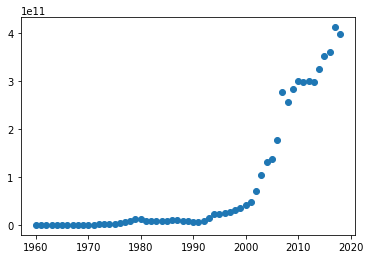

In [43]:
plt.scatter(df['YEARS'],df['TOTAL RESERVE'])
plt.show()

In [44]:
popt, covar = opt.curve_fit(exp_growth, df["YEARS"], df["TOTAL RESERVE"])

Fit parameter [2.10325259e+09 9.33327320e-02]


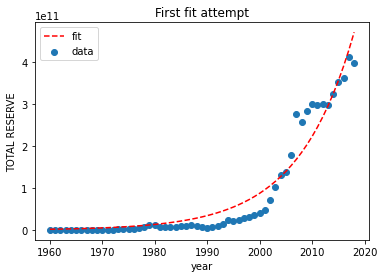

In [7]:
print("Fit parameter", popt)
# use *popt to pass on the fit parameters
df["POP_EXP"] = exp_growth(df["YEARS"], *popt)

plt.figure()
plt.scatter(df["YEARS"], df["TOTAL RESERVE"],label="data")
plt.plot(df["YEARS"], df["POP_EXP"], "--",label="fit",color='r')

plt.legend()
plt.title("First fit attempt")
plt.xlabel("year")
plt.ylabel("TOTAL RESERVE")
plt.show()
print()

Fit parameter [2.10337763e+09 9.33316132e-02]


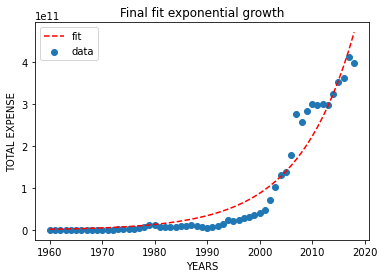

In [14]:
# fit exponential growth
popt, covar = opt.curve_fit(exp_growth, df["YEARS"],
df["TOTAL RESERVE"], p0=[7.242784e+10, 0.05])
# much better
print("Fit parameter", popt)
df["POP_EXP"] = exp_growth(df["YEARS"], *popt)
plt.figure()
plt.scatter(df["YEARS"], df["TOTAL RESERVE"], label="data")
plt.plot(df["YEARS"], df["POP_EXP"],"--", label="fit",color='r')
plt.legend()
plt.xlabel("YEARS")
plt.ylabel("TOTAL EXPENSE")
plt.title("Final fit exponential growth")
plt.show()
print()

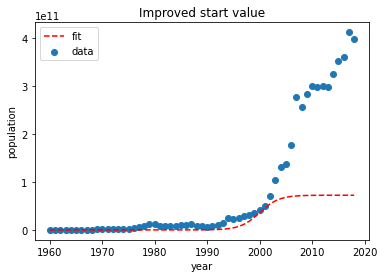

In [15]:
popt = [7.242784e+10, 0.55, 2000]
df["pop_log"] = logistics(df["YEARS"], *popt)
plt.figure()
plt.scatter(df["YEARS"], df["TOTAL RESERVE"], label="data")
plt.plot(df["YEARS"], df["pop_log"],"--", label="fit",color='r')
plt.legend()
plt.xlabel("year")
plt.ylabel("population")
plt.title("Improved start value")
plt.show()

Fit parameter [3.85777938e+11 2.97937034e-01 2.00620759e+03]


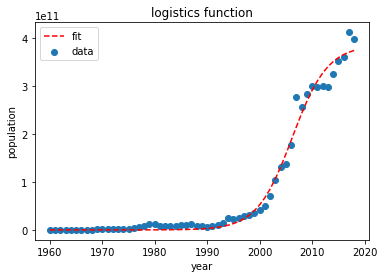

In [16]:
popt, covar = opt.curve_fit(logistics, df["YEARS"], df["TOTAL RESERVE"],
p0=(7.242784e+10, 0.05, 1980.0))
print("Fit parameter", popt)
df["pop_log"] = logistics(df["YEARS"], *popt)
plt.figure()
plt.title("logistics function")
plt.scatter(df["YEARS"], df["TOTAL RESERVE"], label='data')
plt.plot(df["YEARS"], df["pop_log"],"--", label="fit",color='r')
plt.legend()
plt.xlabel("year")
plt.ylabel("population")
plt.show()

In [11]:
def err_ranges(x, func, param, sigma):
    """
    Calculates the upper and lower limits for the function, parameters and
    sigmas for single value or array x. Functions values are calculated for 
    all combinations of +/- sigma and the minimum and maximum is determined.
    Can be used for all number of parameters and sigmas >=1.
    
    This routine can be used in assignment programs.
    """

    import itertools as iter
    
    # initiate arrays for lower and upper limits
    lower = func(x, *param)
    upper = lower
    
    uplow = []   # list to hold upper and lower limits for parameters
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)
        
    return lower, upper   

[1.03340023e+10 2.02874218e-02 3.12301929e-01]


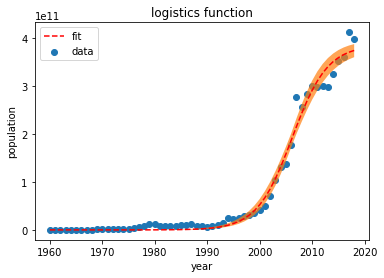

In [17]:
# extract the sigmas from the diagonal of the covariance matrix
sigma = np.sqrt(np.diag(covar))
print(sigma)

low, up = err_ranges(df["YEARS"], logistics, popt, sigma)

plt.figure()
plt.title("logistics function")
plt.scatter(df["YEARS"], df["TOTAL RESERVE"], label="data")
plt.plot(df["YEARS"], df["pop_log"],"--", label="fit",color='r')

plt.fill_between(df["YEARS"], low, up, alpha=0.7)
plt.legend()
plt.xlabel("year")
plt.ylabel("population")
plt.show()


In [13]:
print("Forcasted population")
low, up = err_ranges(2030, logistics, popt, sigma)
print("2030 between ", low, "and", up)
low, up = err_ranges(2040, logistics, popt, sigma)
print("2040 between ", low, "and", up)
low, up = err_ranges(2050, logistics, popt, sigma)
print("2050 between ", low, "and", up)

Forcasted population
2030 between  374891052507.24133 and 395927324697.58167
2040 between  375409467584.6757 and 396104276705.46796
2050 between  375441789583.998 and 396111622289.89777
